### Importación de Librerías

In [15]:
import os
import pandas as pd
from glob import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping


### Importación de Datos

In [2]:
# Define la ruta de las carpetas
base_path = "/Users/davidclemente/Documents/GitHub/DeepLearning_Evidence/lemon_dataset"
categories = {"bad_quality": 0, "empty_background": 1, "good_quality": 2}  # Etiquetas numéricas para cada clase

# Crear listas para almacenar las rutas de las imágenes y sus etiquetas
image_paths = []
labels = []

# Recorre cada categoría y carga las rutas de imágenes y etiquetas
for category, label in categories.items():
    folder_path = os.path.join(base_path, category)
    for image_path in glob(os.path.join(folder_path, "*.jpg")): 
        image_paths.append(image_path)
        labels.append(label)

# Crear un DataFrame para facilitar la manipulación
data = pd.DataFrame({"image_path": image_paths, "label": labels})
data.head()

,image_path,label
0,/Users/davidclemente/Documents/GitHub/DeepLear...,0
1,/Users/davidclemente/Documents/GitHub/DeepLear...,0
2,/Users/davidclemente/Documents/GitHub/DeepLear...,0
3,/Users/davidclemente/Documents/GitHub/DeepLear...,0
4,/Users/davidclemente/Documents/GitHub/DeepLear...,0


### División de Datos

In [4]:
# Divide el dataset en train (70%) y temp (30% que luego dividiremos en val y test)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    data["image_path"], data["label"], test_size=0.3, random_state=42
)

# Divide temp en validation (15%) y test (15%)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, random_state=42
)

# Crea DataFrames para facilitar el manejo
train_data = pd.DataFrame({"image_path": train_paths, "label": train_labels})
val_data = pd.DataFrame({"image_path": val_paths, "label": val_labels})
test_data = pd.DataFrame({"image_path": test_paths, "label": test_labels})

In [5]:
def preprocess_image(file_path, label):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Cambia a decode_png si es PNG
    image = tf.image.resize(image, [300, 300]) / 255.0
    return image, label

# Dataset de entrenamiento
train_dataset = tf.data.Dataset.from_tensor_slices((train_data["image_path"].values, train_data["label"].values))
train_dataset = train_dataset.map(preprocess_image).batch(32)

# Dataset de validación
val_dataset = tf.data.Dataset.from_tensor_slices((val_data["image_path"].values, val_data["label"].values))
val_dataset = val_dataset.map(preprocess_image).batch(32)

# Dataset de prueba
test_dataset = tf.data.Dataset.from_tensor_slices((test_data["image_path"].values, test_data["label"].values))
test_dataset = test_dataset.map(preprocess_image).batch(32)

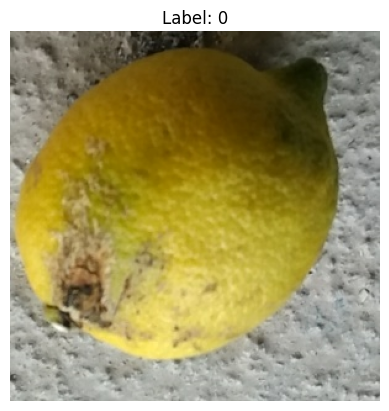

2024-11-08 21:59:52.938813: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
# Obtén un lote de imágenes y etiquetas del dataset
for images, labels in train_dataset.take(1):  
    image = images[0]
    label = labels[0]
    
    # Visualiza la imagen
    plt.imshow(image.numpy())
    plt.title(f"Label: {label.numpy()}")
    plt.axis('off')
    plt.show()

### Modelo

In [7]:
model = Sequential([
    # Primera capa de convolución y pooling
    Conv2D(32, (3, 3), activation='relu', input_shape=(300, 300, 3)),
    MaxPooling2D((2, 2)),
    
    # Segunda capa de convolución y pooling
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # Tercera capa de convolución y pooling
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    
    # # Cuarta capa de convolución y pooling
    # Conv2D(128, (3, 3), activation='relu'),
    # MaxPooling2D((2, 2)),
    
    # Aplanamiento y capas densas
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Dropout para evitar el sobreajuste
    Dense(3, activation='softmax')  # 3 clases: mala calidad, fondo, buena calidad
])

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 156800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    80,282,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,376,899 (306.61 MB)

 Trainable params: 80,376,899 (306.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30, 
    callbacks=[early_stopping]
)

Epoch 1/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 32s 557ms/step - accuracy: 0.5722 - loss: 2.1384 - val_accuracy: 0.8918 - val_loss: 0.3107
Epoch 2/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 543ms/step - accuracy: 0.8982 - loss: 0.2641 - val_accuracy: 0.9314 - val_loss: 0.1780
Epoch 3/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 540ms/step - accuracy: 0.9190 - loss: 0.2066 - val_accuracy: 0.9261 - val_loss: 0.2547
Epoch 4/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 525ms/step - accuracy: 0.9207 - loss: 0.2184 - val_accuracy: 0.9472 - val_loss: 0.1463
Epoch 5/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 29s 521ms/step - accuracy: 0.9410 - loss: 0.1319 - val_accuracy: 0.9551 - val_loss: 0.1316
Epoch 6/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 30s 528ms/step - accuracy: 0.9635 - loss: 0.1218 - val_accuracy: 0.9578 - val_loss: 0.1229
Epoch 7/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 41s 739ms/step - accuracy: 0.9626 - loss: 0.0875 - val_accuracy: 0.9763 - val_loss: 0.0916
Epoch 8/30
56/56 ━━━━━━━━━━━━━━━━━━━━ 50s 885ms/step - accuracy: 0.9733 - loss: 0.0613 - val_accu

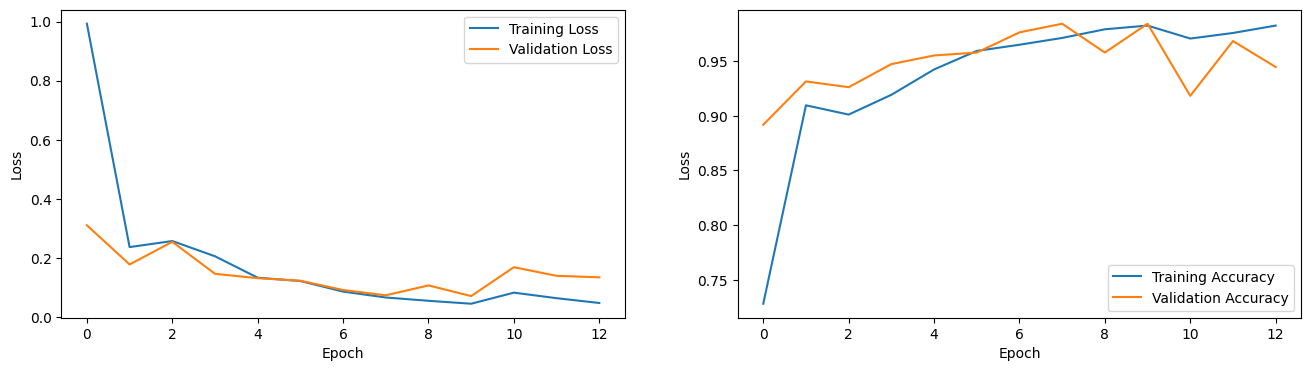

In [12]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(122)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [13]:
# model.save("lemon_model.keras")

### Validación

In [16]:
# Obtener predicciones para todo el dataset de prueba
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)  # Clases predichas

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step


In [21]:
# Extraer etiquetas verdaderas de test_dataset
true_labels = []
for _, labels in test_dataset:
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)

2024-11-08 22:29:37.320792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2024-11-08 22:30:33.617278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


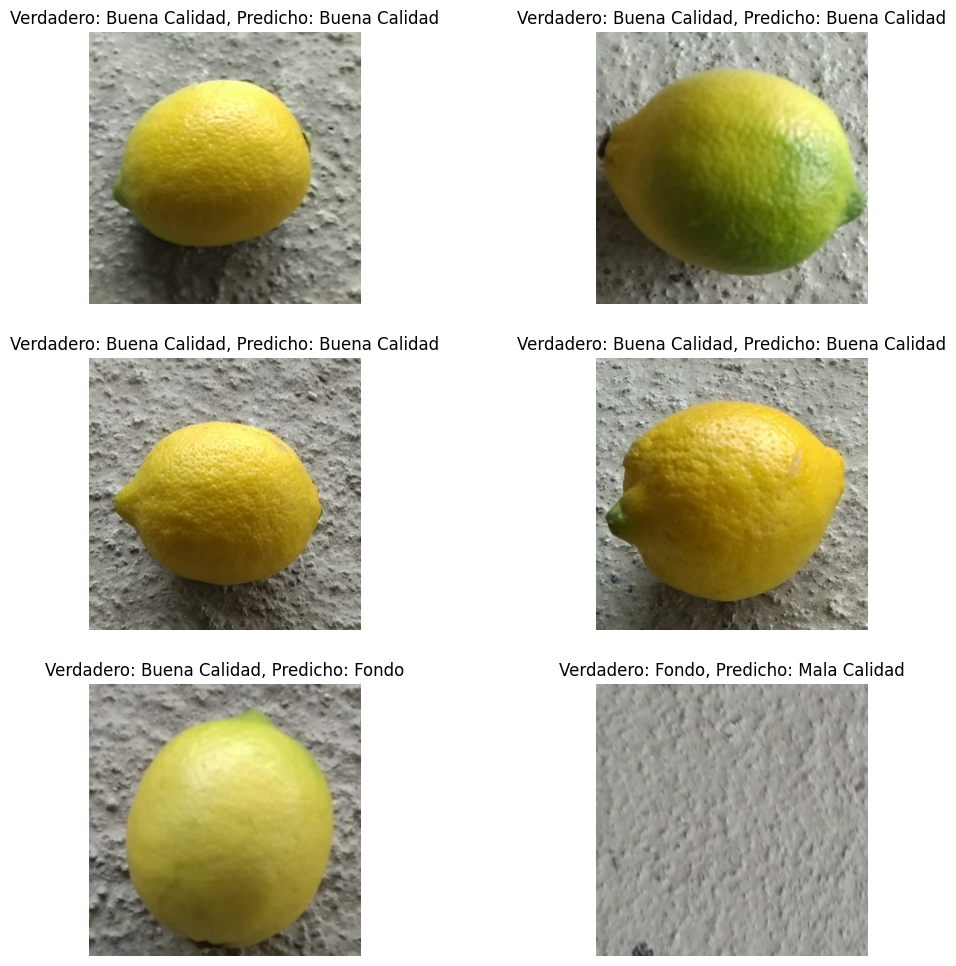

In [ ]:
# Definir nombres de clases
class_names = ["Mala Calidad", "Fondo", "Buena Calidad"]

# Visualizar las primeras 5 imágenes del conjunto de prueba con sus etiquetas
plt.figure(figsize=(12, 12))

# Iterar sobre las primeras 5 imágenes y etiquetas en el dataset de prueba
for i, (images, labels) in enumerate(test_dataset.take(6)):
    # Extraer la primera imagen y su etiqueta del lote
    image = images[0]
    true_label = labels[0].numpy()
    pred_label = predicted_classes[i] 
    
    plt.subplot(3, 2, i + 1)
    plt.imshow(image.numpy())
    plt.title(f"Verdadero: {class_names[true_label]}, Predicho: {class_names[pred_label]}")
    plt.axis('off')

plt.show()

In [19]:
# Evaluar el rendimiento en el conjunto de prueba
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Precisión en el conjunto de prueba: {test_acc}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step - accuracy: 0.9972 - loss: 0.0200
Precisión en el conjunto de prueba: 0.99210524559021


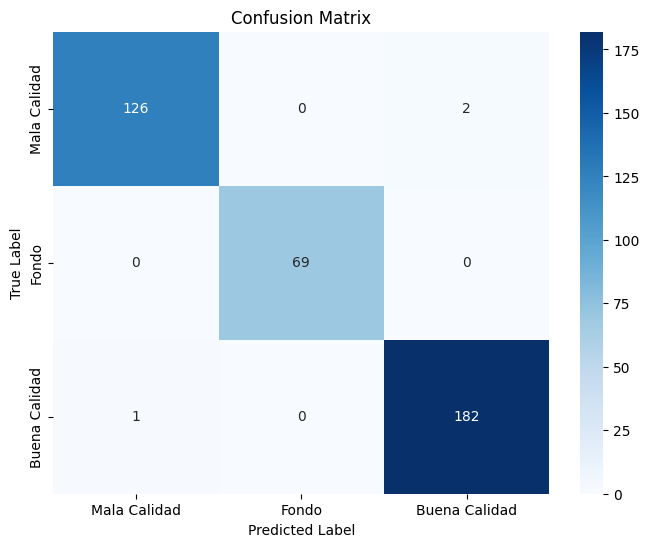

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Genera la matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Define los nombres de las clases
class_names = ["Mala Calidad", "Fondo", "Buena Calidad"]

# Visualiza la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

1. Análisis de las Gráficas de Pérdida y Precisión

- Pérdida (Loss): La gráfica de pérdida muestra una caída rápida en las primeras épocas, seguida de una estabilización tanto en el conjunto de entrenamiento como en el de validación. La pérdida de validación es ligeramente mayor que la de entrenamiento en las últimas épocas, lo cual podría indicar un leve sobreajuste, aunque el gap entre ambas no es significativo.
- Precisión (Accuracy): La precisión en el conjunto de entrenamiento y validación es alta y se estabiliza alrededor del 95% al final de las épocas. La cercanía entre la precisión de entrenamiento y validación indica que el modelo ha aprendido bien sin sobreajustarse demasiado, lo cual es un buen indicador de rendimiento en general.

Conclusión sobre las Gráficas: El modelo parece tener un rendimiento consistente en los datos de entrenamiento y validación, con alta precisión y una pérdida estable, lo cual sugiere que el modelo está bien ajustado y generaliza bien.

2. Análisis de la Matriz de Confusión

- Clase “Mala Calidad”: El modelo clasifica correctamente 126 de los ejemplos de “Mala Calidad”, con solo 2 errores, donde clasifica erróneamente imágenes de esta clase como “Buena Calidad”. Esto indica un alto nivel de precisión para esta clase.
- Clase “Fondo”: El modelo clasifica correctamente todos los ejemplos de “Fondo” con una precisión perfecta (69 aciertos y 0 errores), lo cual sugiere que esta clase es claramente distinguible de las demás.
- Clase “Buena Calidad”: Se clasifica correctamente la mayoría de los ejemplos de “Buena Calidad” (182 aciertos y solo 1 error donde se clasificó incorrectamente como “Mala Calidad”).

La matriz de confusión muestra que el modelo tiene un alto nivel de precisión en todas las clases, con muy pocos errores de clasificación. Esto sugiere que el modelo ha aprendido bien a distinguir entre las diferentes clases de calidad de limones y el fondo.

### Conclusión General

El modelo de clasificación ha alcanzado un rendimiento alto, con una precisión que supera el 95% en el conjunto de validación y una baja pérdida, lo cual es consistente con los resultados de la matriz de confusión. La pequeña cantidad de errores sugiere que el modelo es robusto para clasificar las diferentes categorías con pocas confusiones entre clases. Además, el leve sobreajuste observado en la gráfica de pérdida podría mejorarse aplicando técnicas adicionales como una mayor regularización o data augmentation.

En resumen, el modelo parece ser adecuado para la tarea de clasificación de calidad de limones y es capaz de generalizar bien en datos no vistos.